In [21]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [3]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


Features and Label

In [4]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

(253680, 21)

Train/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Features selection with backword stepwise elimination (with multinominal logistische regression)

In [ ]:
#Add constant for intercept
def multinomial(X): 
    X = sm.add_constant(X)
    cols = list(X.columns)
    pmax = 1

    while len(cols) > 0:
        # Inside your while loop:
        model = sm.MNLogit(y, X[cols]).fit(disp=0)

        # Take max p-value per feature across classes
        p_values = model.pvalues
        p_values_max = p_values.max(axis=1)
        pmax = p_values_max.max()
        feature_with_p_max = p_values_max.idxmax()

        # Backward elimination step
        if pmax > 0.05:
            print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
            cols.remove(feature_with_p_max)
        else:
            break

    print(f"Selected features: {cols}")
    return cols

X_BSE_list = multinomial(X)
X_BSE_list.remove('const')
X_postBSE = X[X_BSE_list]


Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']


Feature selection with RF

Best k: 8, Best score: 0.39852736906696873


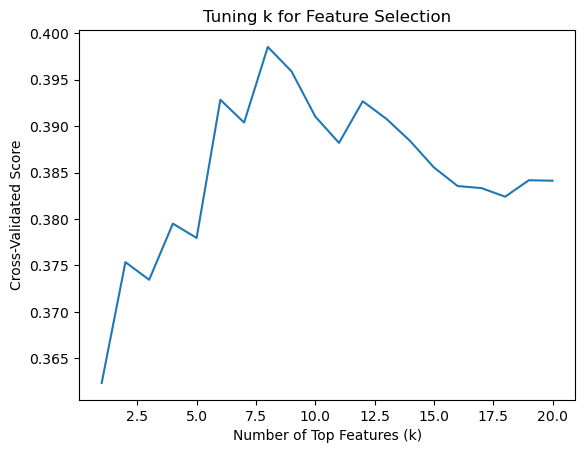

In [14]:
temp_rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
temp_rdf.fit(X_train, y_train)

# Create importance_df
importances = temp_rdf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

scores = []
k_list = list(range(1, 21))
for k in k_list:
    selected_features = importance_df['Feature'].head(k).values
    X_train_selected = X_train[selected_features]
    
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='f1_macro')
    scores.append(np.mean(cv_scores))

# Find best k
best_k = k_list[np.argmax(scores)]
print(f"Best k: {best_k}, Best score: {max(scores)}")

# Optionally plot
import matplotlib.pyplot as plt
plt.plot(k_list, scores)
plt.xlabel('Number of Top Features (k)')
plt.ylabel('Cross-Validated Score')
plt.title('Tuning k for Feature Selection')
plt.show()

In [15]:
top_features = importance_df['Feature'].head(best_k).values

X_best_features = X[top_features]


Feature selection with SelectKBest and find best k

In [ ]:
# === initialize dataframe for readout ===
kbest_df = pd.DataFrame({"Selected Feature": [],
            "Accuracy" : [],
            'Precision': [],
            'Recall':    [],
            'F1 Score':  []})
# === Feature selection with selectKbest ===
for i in range(1,22):
    selector = SelectKBest(score_func=mutual_info_classif,k=i)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # === Random forest with balanced class weights ===
    rdf = RandomForestClassifier(class_weight='balanced', random_state=42)
    rdf.fit(X_train_selected, y_train)
    y_pred = rdf.predict(X_test_selected)

    # === Evaluate ===
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    #kbest_df.loc[i, "Selected Feature"] = str(selected_features)
    kbest_df.loc[i, "Accuracy"] = accuracy
    kbest_df.loc[i, 'Precision'] = precision
    kbest_df.loc[i, 'Recall'] = recall
    kbest_df.loc[i, 'F1 Score'] = f1
kbest_df

/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Selected Feature,Accuracy,Precision,Recall,F1 Score
1,NaN,0.634244,0.390131,0.459072,0.372282
2,NaN,0.606216,0.423613,0.483322,0.398417
3,NaN,0.600166,0.426464,0.490142,0.398235
4,NaN,0.625374,0.425982,0.484142,0.404456
5,NaN,0.622832,0.425178,0.478705,0.402403
6,NaN,0.643074,0.421939,0.471043,0.404892
7,NaN,0.661660,0.419254,0.460955,0.407241
8,NaN,0.674137,0.414650,0.449569,0.405889
9,NaN,0.725106,0.407235,0.420206,0.405156
10,NaN,0.775978,0.407317,0.397415,0.400682


In [18]:
# Split training/test
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best_features, y, test_size=0.2, random_state=42, stratify=y)


Features selection togheter with hyperparametertuning

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time=  13.0s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time=  13.1s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time=  13.1s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time=  13.6s
[CV] END feature_selection__k=1, rf__bootstrap=False, rf__max_depth=5, rf__max_features=sqrt, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=150; total time=  14.1s
[CV] END feat

/Users/miniconda3/envs/fods/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END feature_selection__k=7, rf__bootstrap=False, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=300; total time=  38.3s
[CV] END feature_selection__k=4, rf__bootstrap=False, rf__max_depth=20, rf__max_features=0.5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  15.1s
[CV] END feature_selection__k=4, rf__bootstrap=False, rf__max_depth=20, rf__max_features=0.5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  18.1s
[CV] END feature_selection__k=7, rf__bootstrap=False, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=300; total time=  38.7s
[CV] END feature_selection__k=7, rf__bootstrap=False, rf__max_depth=None, rf__max_features=log2, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=300; total time=  39.6s
[CV] END feature_selection__k=11, rf__bootstrap=True, rf__max_depth=

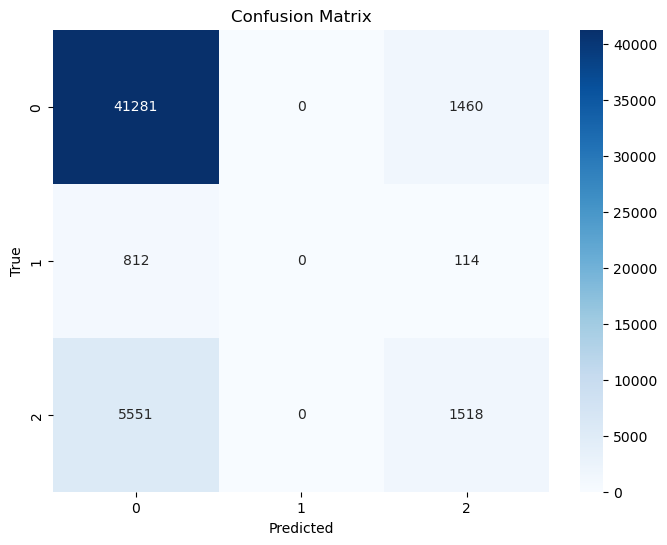

Best parameters from tuning: {'rf__n_estimators': 150, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': None, 'rf__bootstrap': False, 'feature_selection__k': 19}
Best CV score (macro F1): 0.4032710345235614
Accuracy: 0.8435627562283191
Precision (macro): 0.45246378478531063
Recall (macro): 0.3935270592327385
F1 Score (macro): 0.40407917236807805

Classification Report:

              precision    recall  f1-score   support

           0     0.8664    0.9658    0.9134     42741
           1     0.0000    0.0000    0.0000       926
           2     0.4909    0.2147    0.2988      7069

    accuracy                         0.8436     50736
   macro avg     0.4525    0.3935    0.4041     50736
weighted avg     0.7983    0.8436    0.8111     50736



/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/miniconda3/envs/fods/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [ ]:
# === Pipeline definition ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('rf', RandomForestClassifier(random_state=42))
])

# === Combined hyperparameter grid ===
param_dist = {
    'feature_selection__k': list(range(1, X_train.shape[1] + 1)),  # test all k from 1 to total features
    'rf__n_estimators': [50, 100, 150, 200, 300, 500],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False]
}

# === Cross-validated randomized search ===
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# === Fit search on full training set ===
random_search.fit(X_train, y_train)

# === Evaluate on hold-out test set ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === Metrics ===
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score (macro F1):", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.0s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.0s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.2s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.2s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.4s
[CV] END bootstrap=False, max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  11.0s
[CV] END bootstrap=False, max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=  

/Users/miniconda3/envs/fods/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  25.4s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  25.8s
[CV] END bootstrap=True, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=15, max_features=0.5, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=False, max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  11.8s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  25.4s
[CV] END bootstrap=False, max_depth=None, max_feat

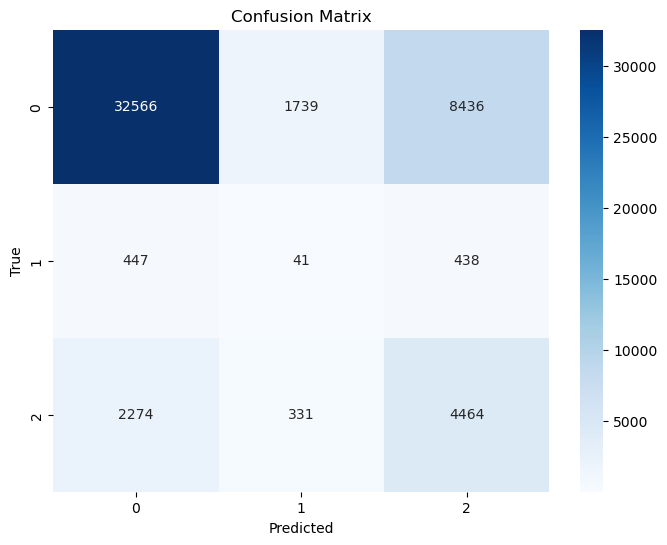

Best parameters from tuning: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': True}
Best CV score (macro F1): 0.436831270835537
Accuracy: 0.7306646168401135
Precision (macro): 0.4256647950723284
Recall (macro): 0.47923474873000343
F1 Score (macro): 0.4330744207980388

Classification Report:

              precision    recall  f1-score   support

           0     0.9229    0.7619    0.8347     42741
           1     0.0194    0.0443    0.0270       926
           2     0.3347    0.6315    0.4375      7069

    accuracy                         0.7307     50736
   macro avg     0.4257    0.4792    0.4331     50736
weighted avg     0.8244    0.7307    0.7646     50736



In [20]:
# === Combined hyperparameter grid ===
param_dist = {
    'n_estimators': [50, 100, 150, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False]
}

# === Cross-validated randomized search ===
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# === Fit search on full training set ===
random_search.fit(X_train_best, y_train_best)

# === Evaluate on hold-out test set ===
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_best)
y_proba = best_model.predict_proba(X_test_best)

# === Confusion Matrix ===
cm = confusion_matrix(y_test_best, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === Metrics ===
print("Best parameters from tuning:", random_search.best_params_)
print("Best CV score (macro F1):", random_search.best_score_)
print("Accuracy:", accuracy_score(y_test_best, y_pred))
print("Precision (macro):", precision_score(y_test_best, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test_best, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test_best, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test_best, y_pred, digits=4))

After Hypeparameter tuning

In [ ]:
# RANDOM FOREST
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_best_features, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
rdf.fit(X_train, y_train)

# Prediction
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))


Let's try also grid search and not randomized search

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.7s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.7s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.8s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  18.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  18.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  26.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total

/Users/miniconda3/envs/fods/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.2s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  27.5s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  26.7s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  40.4s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  40.7s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  41.2s
[CV] END bootstrap=True, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  26.6s
[CV] END bootstrap=True, max_depth=15, max_featu

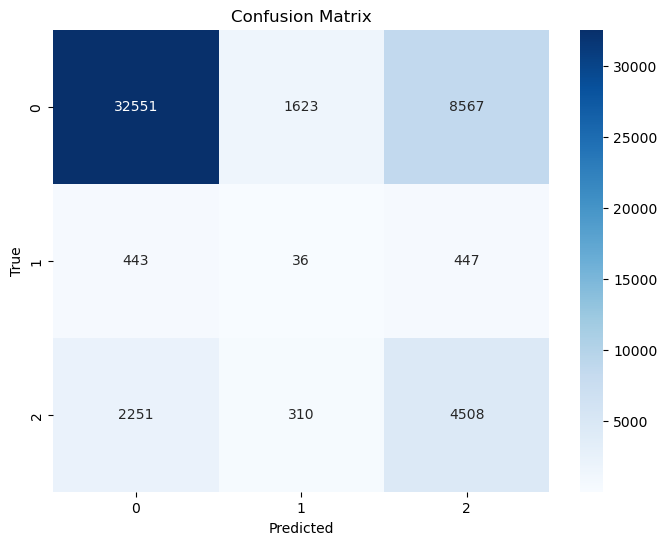

Best parameters from tuning: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score (macro F1): 0.43722772977423646
Accuracy: 0.7311376537369915
Precision (macro): 0.42507655144536455
Recall (macro): 0.47939269565306825
F1 Score (macro): 0.4325075092383244

Classification Report:

              precision    recall  f1-score   support

           0     0.9236    0.7616    0.8348     42741
           1     0.0183    0.0389    0.0249       926
           2     0.3334    0.6377    0.4379      7069

    accuracy                         0.7311     50736
   macro avg     0.4251    0.4794    0.4325     50736
weighted avg     0.8248    0.7311    0.7647     50736



In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# === Combined hyperparameter grid ===
param_grid = {
    'n_estimators': [200, 300], 
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2', 'sqrt'],
    # Stable parameters after randomized search
    'min_samples_split': [2],
    'bootstrap': [True]
}

# === Grid Search ===
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

# === Fit search on full training set ===
grid_search.fit(X_train_best, y_train_best)

# === Evaluate on hold-out test set ===
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_best)
y_proba = best_model.predict_proba(X_test_best)

# === Confusion Matrix ===
cm = confusion_matrix(y_test_best, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === Metrics ===
print("Best parameters from tuning:", grid_search.best_params_)
print("Best CV score (macro F1):", grid_search.best_score_)
print("Accuracy:", accuracy_score(y_test_best, y_pred))
print("Precision (macro):", precision_score(y_test_best, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test_best, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test_best, y_pred, average='macro'))
print("\nClassification Report:\n")
print(classification_report(y_test_best, y_pred, digits=4))
